## General Description

In this notebook I will explore networks and develop MRJob code for finding shortest path graph distances. To build up to large data I will develop my code on some very simple, toy networks.
After this I will take my developed code forward and modify it and apply it to two larger datasets (performing EDA along the way).

### Undirected toy network dataset


In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt


In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


### Directed toy network dataset

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

## Section 1: Shortest path graph distances (toy networks)
I am going to write MRJob classes to find shortest path graph distances. In addition to finding the distances, my code will also output a distance-minimizing path between the source and target.
I will be working locally for this part of the notebook, and use both of the undirected and directed toy networks.


- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice.

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5



### Main dataset 1: NLTK synonyms

In the next part of this notebook, I will explore a network derived from the NLTK synonym database. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

<a href="s3://ucb-mids-mls-networks/synNet/synNet.txt">s3://ucb-mids-mls-networks/synNet/synNet.txt</a>
<a href="s3://ucb-mids-mls-networks/synNet/indices.txt">s3://ucb-mids-mls-networks/synNet/indices.txt</a>

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


In [1]:
%%writefile directed_toy_graph.txt
1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting directed_toy_graph.txt


In [2]:
%%writefile undirected_toy_graph.txt
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting undirected_toy_graph.txt


In [3]:
%%writefile undirected_weighted_toy_graph.txt
1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

Overwriting undirected_weighted_toy_graph.txt


In [4]:
!cat directed_toy_graph.txt
print "\n","-"*100
!cat undirected_toy_graph.txt
print "\n","-"*100
!cat undirected_weighted_toy_graph.txt

1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}
----------------------------------------------------------------------------------------------------
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}
----------------------------------------------------------------------------------------------------
1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

<img src="http://www.candpgeneration.com/images/graphs.png" style="float:left;"/>

In [5]:
!hdfs dfs -ls hdfs:///tmp/hw7/
!hdfs dfs -ls hdfs:///tmp/msannat

Found 2 items
-rwxrwxrwx   3 scottmarler hdfs  517438296 2017-03-11 22:43 hdfs:/tmp/hw7/wiki_indices.txt
-rwxrwxrwx   3 scottmarler hdfs 2090459616 2017-03-11 22:43 hdfs:/tmp/hw7/wiki_out.txt
Found 6 items
-rw-r--r--   3 manishsannat hdfs        110 2017-03-12 23:22 hdfs:/tmp/msannat/directed_toy_graph_input.txt
drwxr-xr-x   - manishsannat hdfs          0 2017-03-13 00:50 hdfs:/tmp/msannat/output
-rw-r--r--   3 manishsannat hdfs     705298 2017-03-12 23:24 hdfs:/tmp/msannat/synNet_input.txt
drwxr-xr-x   - manishsannat hdfs          0 2017-03-14 04:22 hdfs:/tmp/msannat/temp-output
-rw-r--r--   3 manishsannat hdfs        120 2017-03-13 20:11 hdfs:/tmp/msannat/undirected_toy_graph_input.txt
-rw-r--r--   3 manishsannat hdfs 2090459616 2017-03-12 23:24 hdfs:/tmp/msannat/wiki_out_input.txt


In [6]:
%%writefile BFSParallel.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys


class BFSParallel(MRJob):
    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,
                       mapper=self.mapper,
                       combiner=None,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       reducer_final=self.reducer_final)
                ]
    
    
    def configure_options(self):
        super(BFSParallel, self).configure_options()
        self.add_passthrough_option('--startnode', default='1', type=str, help='starting node for single source shortest path')
        self.add_passthrough_option('--endnode', default=None, type=str, help='target node to be visited')
    
    def mapper_init(self):
        self.startnode = self.options.startnode
    
    
    def mapper(self, _, line):
        
        distance = sys.maxint
        path =[]
        status= None
        node = None
        edges = None
        
        node, graph_values = line.strip().split('\t')
        node =  node.strip('"')
        values = graph_values.strip('"').split("|")
        edges = ast.literal_eval(values[0])

        if len(values) == 4:
            distance = int(values[1])
            path = ast.literal_eval(values[2])
            status = values[3]
        
        if status == None:
            if self.startnode == node:
                distance = 0
                status = 'queued'
        if status == 'queued':
            yield node, (edges, distance, path,  'visited')
            path.append(node)
            for node in edges.iterkeys():
                yield node, (None,  distance+1, path,'queued')
        else:
            yield node, (edges,  distance, path,status)



    def reducer_init(self):
        self.endnode = self.options.endnode
        self.endnode_reached = False
        self.final_path = None


    def reducer(self, key, values):
        edges = {}
        distance= []
        status = []
        path = []
        curr_state = None
        
        
        for value in values:
            edges_t = value[0]
            path_t = value[2]
            distance_t = value[1]
            status_t = value[3]
            
            if status_t == 'visited':
                path = path_t
                edges = edges_t
            else:
                if edges_t != None:
                    edges = edges_t
                if path_t != None and len(path_t) > 0:
                    path = path_t
            distance.append(distance_t)
            status.append(status_t)
        min_distance = min(distance)


        if 'visited' in status:
            curr_state = 'visited'
            if self.endnode != None and key.strip('"') == self.endnode:
                self.endnode_reached = True
                self.final_path = str(key) + "\t" + str(edges) + '|' + str(min_distance) + '|' + str(path) + '|' + "F"
        elif 'queued' in status:
            curr_state = 'queued'
        else:
            curr_state = 'unvisited'

        yield key, str(edges) + '|' + str(min_distance) + '|' + str(path) + '|' + curr_state
    
    def reducer_final(self):
        if self.endnode_reached:
            yield self.final_path.split('\t')[0], self.final_path.split('\t')[1]


if __name__ == '__main__':
    BFSParallel.run()



Overwriting BFSParallel.py


In [7]:
%%writefile BFSParallel_driver.py
# DRIVER
from BFSParallel import BFSParallel
import sys
import ast
import subprocess

INPUT_GRAPH = sys.argv[1]
START_NODE = sys.argv[2]
END_NODE = sys.argv[3]

mr_job = BFSParallel(args=[INPUT_GRAPH, '--startnode', START_NODE, '--endnode', END_NODE,  '-r', 'hadoop', '--no-output', '--cleanup', 'NONE', '--no-check-input-paths', '--output-dir',  '/tmp/msannat/temp-output' ])
#mr_job = BFSParallel(args=[INPUT_GRAPH, '--startnode', START_NODE, '--endnode', END_NODE,  '-r', 'local' ])

num_interation = 0
endnode_reached = False

while (1):
    with mr_job.make_runner() as runner: 
        num_interation += 1
        print "Iteration: ", num_interation
        subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
        runner.run()
        f = open(INPUT_GRAPH, 'w+')
        #cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-00000"], stdout=subprocess.PIPE)
        cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
        for line in cat.stdout:
        #for line in runner.stream_output():
            f.writelines(line)
            
            line = line.split('\t')
            node = line[0].strip('"')
            data = line[1].strip('"').split('|')
            edges = data[0]
            distance = data[1]
            path = data[2]
            status = data[3].replace('"', "")

            if status[0] == 'F' :
                min_distance = distance
                endnode_reached = True
                path = ast.literal_eval(path)
                shortest_path = ' -> '.join(path) + " -> " + node
            
        if endnode_reached:
            break
    f.close()

print "number of iterations {}".format(num_interation)
print "shortest distance from node {} to node {} is: {} with path: [{}]".format(START_NODE, END_NODE, min_distance, shortest_path)

# DRIVER

Overwriting BFSParallel_driver.py


In [8]:
!chmod a+x ./BFSParallel_driver.py

In [9]:
!hdfs dfs -rm -r hdfs:///tmp/msannat/temp-output
!hdfs dfs -ls hdfs:///tmp/msannat/temp-output

17/03/14 05:03:58 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
ls: `hdfs:///tmp/msannat/temp-output': No such file or directory


In [10]:
!cp ./undirected_toy_graph.txt ./undirected_toy_graph_input.txt
!python ./BFSParallel_driver.py ./undirected_toy_graph_input.txt 1 4

Iteration:  1
rm: `/tmp/msannat/temp-output/': No such file or directory
Iteration:  2
17/03/14 05:04:59 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  3
17/03/14 05:07:20 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
number of iterations 3
shortest distance from node 1 to node 4 is: 2 with path: [1 -> 5 -> 4]


In [11]:
!cp ./directed_toy_graph.txt ./directed_toy_graph_input.txt
!python ./BFSParallel_driver.py ./directed_toy_graph_input.txt 1 5

Iteration:  1
17/03/14 05:09:16 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  2
17/03/14 05:10:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  3
17/03/14 05:12:17 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  4
17/03/14 05:13:56 INFO fs.TrashPolicyDefault: Namenode trash conf

## Section 2: Exploratory data analysis (NLTK synonyms)
Using MRJob, I am going to explore the synonyms network data.
I am going to plot the degree distribution (it follows a power law), and determine some of the key features, like:
number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As I develop my code, I am going to run it locally first (though on the whole dataset). 
Once I have gotten the code to run locally, I will deploy it on AWS as a systems test in preparation for our next dataset (which will require AWS).


In [12]:
! cat synNet.txt | head -n10
#! cat indices.txt | head -n10

1	{'2': 1, '3': 1, '4': 1}
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}
3	{'1': 1, '2': 1, '4': 1}
4	{'1': 1, '2': 1, '3': 1, '311': 1}
5	{'6': 1}
6	{'5': 1}
7	{'8': 1, '9': 1}
8	{'7': 1, '9': 1}
9	{'7': 1, '8': 1, '124': 1, '1316': 1}
10	{'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '16': 1, '17': 1}
cat: write error: Broken pipe


In [13]:
%%writefile nltksynonymsexpldataanalysis.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
 


class ntlksynexpldataanalysis(MRJob):
    
    
    def mapper_init(self):
        pass
    
    def mapper(self, _, line): 
        node, neighbors_string = line.split('\t')
        neighbors = ast.literal_eval(neighbors_string)
        yield node, len(neighbors)
                 
    def reducer_init(self):
        self.num_nodes = 0
        self.num_links = 0
                    
    def reducer(self, key, values):
        self.num_nodes+=1
        self.num_links+= sum( values)
        
    def reducer_final(self):
        yield 'avg', (self.num_nodes, self.num_links)
        
                    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,
                       mapper=self.mapper,
                       combiner=None,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       reducer_final=self.reducer_final)                
            ]


        
if __name__ == '__main__':
    ntlksynexpldataanalysis.run()

Overwriting nltksynonymsexpldataanalysis.py


In [14]:

from nltksynonymsexpldataanalysis import ntlksynexpldataanalysis
mr_job = ntlksynexpldataanalysis(args=[ '-r', 'local' , 'synNet.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    num_nodes = 0
    num_links = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        num_nodes+= int(value[0])
        num_links+= int(value[1])
        #print value
print "\n*****************************"
print "Number of nodes: %s" %num_nodes
print "Number of links: %s" %num_links
print "Average degree: %.2f" %(num_nodes*1.0/num_links)
print "\n*****************************"



*****************************
Number of nodes: 8271
Number of links: 61134
Average degree: 0.14

*****************************


In [15]:
%%writefile nltksynonymspowerlawdist.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
 


class nltksynonymspowerlaw(MRJob):
    
    def mapper(self, _, line): 
        node, neighbors_string = line.split('\t')
        neighbors = ast.literal_eval(neighbors_string)
        yield node, len(neighbors)   
                    
    def steps(self):
        return [MRStep(mapper=self.mapper)                
            ]


        
if __name__ == '__main__':
    nltksynonymspowerlaw.run()

Overwriting nltksynonymspowerlawdist.py


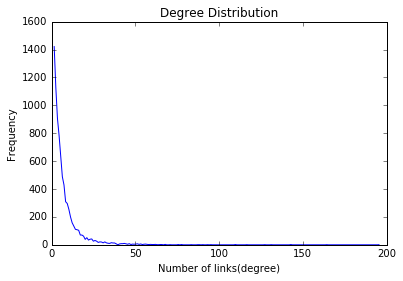

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from nltksynonymspowerlawdist import nltksynonymspowerlaw
mr_job = nltksynonymspowerlaw(args=[ '-r', 'local' , 'synNet.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    links_dist = []
    links_dist_dict = {}
    
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        links_dist.append(value)
        links_dist_dict[key] = value

y,binEdges=np.histogram(links_dist,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.title("Degree Distribution")
plt.xlabel("Number of links(degree)")
plt.ylabel("Frequency")
plt.show()



### It does seem to follow a power law.

## Section 3: Shortest path graph distances (NLTK synonyms)
I am going to write (reuse code from section 1 above) an MRJob class to find shortest path graph distances, and apply it to the NLTK synonyms network dataset. 

Proof the code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing the code's output. Once again, output will include the path and the distance.

As I develop my code, please be sure to run it locally first (though on the whole dataset). 
Once I have gotten the code to run locally, I will deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

=====================================
<strong>NOTE: Dataset 2 English Wikipedia hyperlink network.data </strong>
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at 
<a href="s3://ucb-mids-mls-networks/wikipedia/">s3://ucb-mids-mls-networks/wikipedia/</a>
<a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a> # Graph
<a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a> # Page titles and page Ids

For the remainder of this notebook I will explore the English Wikipedia hyperlink network.

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a>

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

</pre>
</div>

In [21]:
%%writefile BFSParallelNLTKSynonyms.py


from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys


class BFSParallelNLTKSynonyms(MRJob):
    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,
                       mapper=self.mapper,
                       combiner=None,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       reducer_final=self.reducer_final)
                ]
    
    
    def configure_options(self):
        super(BFSParallelNLTKSynonyms, self).configure_options()
        self.add_passthrough_option('--startnode', default='1', type=str, help='start node for single source shortest path')
        self.add_passthrough_option('--endnode', default=None, type=str, help='target node to be visited')
    
    def mapper_init(self):
        self.startnode = self.options.startnode
    
    
    def mapper(self, _, line):
        
        distance = sys.maxint
        path =[]
        status= None
        node = None
        edges = None
        
        node, graph_values = line.strip().split('\t')
        node =  node.strip('"')
        values = graph_values.strip('"').split("|")
        edges = ast.literal_eval(values[0])

        if len(values) == 4:
            distance = int(values[1])
            path = ast.literal_eval(values[2])
            status = values[3]
        
        if status == None:
            if self.startnode == node:
                distance = 0
                status = 'queued'
        if status == 'queued':
            yield node, (edges, distance, path,  'visited')
            path.append(node)
            for node in edges.iterkeys():
                yield node, (None,  distance+1, path,'queued')
        else:
            yield node, (edges,  distance, path,status)



    def reducer_init(self):
        self.endnode = self.options.endnode
        self.endnode_reached = False
        self.final_path = None


    def reducer(self, key, values):
        edges = {}
        distance= []
        status = []
        path = []
        curr_state = None
        
        
        for value in values:
            edges_t = value[0]
            path_t = value[2]
            distance_t = value[1]
            status_t = value[3]
            
            if status_t == 'visited':
                path = path_t
                edges = edges_t
            else:
                if edges_t != None:
                    edges = edges_t
                if path_t != None and len(path_t) > 0:
                    path = path_t
            distance.append(distance_t)
            status.append(status_t)
        min_distance = min(distance)


        if 'visited' in status:
            curr_state = 'visited'
            if self.endnode != None and key.strip('"') == self.endnode:
                self.endnode_reached = True
                self.final_path = str(key) + "\t" + str(edges) + '|' + str(min_distance) + '|' + str(path) + '|' + "F"
        elif 'queued' in status:
            curr_state = 'queued'
        else:
            curr_state = 'unvisited'

        yield key, str(edges) + '|' + str(min_distance) + '|' + str(path) + '|' + curr_state
    
    def reducer_final(self):
        if self.endnode_reached:
            yield self.final_path.split('\t')[0], self.final_path.split('\t')[1]


if __name__ == '__main__':
    BFSParallelNLTKSynonyms.run()



Overwriting BFSParallelNLTKSynonyms.py


In [22]:
%%writefile BFSParallelNLTKSynonyms_driver.py

from BFSParallelNLTKSynonyms import BFSParallelNLTKSynonyms
import sys
import ast
import subprocess

def ind_lookup(path):
    node_words = []
    with open("indices.txt","r") as f:
        for line in f.readlines():
            word,index = line.strip().split("\t")
            if int(index) in path:
                node_words.append(word)
    return node_words 


INPUT_GRAPH = sys.argv[1]
START_NODE = sys.argv[2]
END_NODE = sys.argv[3]

mr_job = BFSParallelNLTKSynonyms(args=[INPUT_GRAPH, '--startnode', START_NODE, '--endnode', END_NODE,  '-r', 'hadoop', '--no-output', '--cleanup', 'NONE', '--no-check-input-paths', '--output-dir',  '/tmp/msannat/temp-output' ])
#mr_job = BFSParallelNLTKSynonyms(args=[INPUT_GRAPH, '--startnode', START_NODE, '--endnode', END_NODE,  '-r', 'local' ])

num_interation = 0
endnode_reached = False
#shortest_path_words = []

while (1):
    with mr_job.make_runner() as runner: 
        num_interation += 1
        print "Iteration: ", num_interation
        subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
        runner.run()
        if num_interation ==1:
            #INPUT_GRAPH = 'undirected_toy_graph_input.txt'
            f = open(INPUT_GRAPH, 'w+')
        else:
            #INPUT_GRAPH = 'undirected_toy_graph_input.txt'
            f = open(INPUT_GRAPH, 'w+')
            
        #cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-00000"], stdout=subprocess.PIPE)
        cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
        for line in cat.stdout:
        #for line in runner.stream_output():
            f.writelines(line)
            
            line = line.split('\t')
            node = line[0].strip('"')
            data = line[1].strip('"').split('|')
            edges = data[0]
            distance = data[1]
            path = data[2]
            status = data[3].replace('"', "")

            if status[0] == 'F' :
                min_distance = distance
                endnode_reached = True
                path = ast.literal_eval(path)
                shortest_path = ' -> '.join(path) + " -> " + node
                #shortest_path_words = ' -> '.join(ind_lookup(path))  + ' -> ' + ' -> '.join(ind_lookup([node]))
                shortest_path_words = ' -> '.join(ind_lookup([int(v) for v in path]))  + ' -> ' + ' -> '.join(ind_lookup([int(node)]))

                
            
        if endnode_reached:
            break
    f.close()


print "number of iterations {}".format(num_interation)
print "shortest distance from node {} to node {} is: {} with path: [{}] and words : [{}] ".format(START_NODE, END_NODE, min_distance, shortest_path, shortest_path_words)



Overwriting BFSParallelNLTKSynonyms_driver.py


In [23]:

!cp ./synNet.txt ./synNet_input.txt
!python ./BFSParallelNLTKSynonyms_driver.py ./synNet_input.txt 7827 536



Iteration:  1
17/03/14 05:23:45 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  2
17/03/14 05:27:37 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  3
17/03/14 05:29:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
Iteration:  4
17/03/14 05:32:17 INFO fs.TrashPolicyDefault: Namenode trash conf

## Section 4: Exploratory data analysis (Wikipedia)
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse the code from section 2. 

Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 

This means that I may have to ADJUST my code (depending on its design). 

To be sure of the code's functionality in this context, run a systems test on the directed_toy.txt network.


In [24]:
%%writefile wikipediaexpldataanalysis.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast


class wikipediaexpldataanalysis(MRJob):
    
    
    def mapper_init(self):
        pass
    
    def mapper(self, _, line): 
        node, neighbors_string = line.split('\t')
        neighbors = ast.literal_eval(neighbors_string)
        yield node, len(neighbors)
                 
    def reducer_init(self):
        self.num_nodes = 0
        self.num_links = 0
                    
    def reducer(self, key, values):
        self.num_nodes+=1
        self.num_links+= sum( values)
        
    def reducer_final(self):
        yield 'avg', (self.num_nodes, self.num_links)
        
                    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,
                       mapper=self.mapper,
                       combiner=None,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       reducer_final=self.reducer_final)                
            ]


        
if __name__ == '__main__':
    wikipediaexpldataanalysis.run()

Overwriting wikipediaexpldataanalysis.py


In [25]:
!hdfs dfs -rm -r hdfs:///tmp/msannat/temp-output
!hdfs dfs -ls hdfs:///tmp/msannat/temp-output

17/03/14 05:36:18 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
ls: `hdfs:///tmp/msannat/temp-output': No such file or directory


In [27]:
from wikipediaexpldataanalysis import wikipediaexpldataanalysis
import subprocess
mr_job = wikipediaexpldataanalysis(args=['hdfs:///tmp/hw7/wiki_out.txt', '-r', 'hadoop' , 
                                         '--no-output', '--cleanup', 'NONE', '--output-dir',  '/tmp/msannat/temp-output'])
with mr_job.make_runner() as runner: 
    subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
    runner.run()
    num_nodes = 0
    num_links = 0
    # stream_output: get access of the output 
    cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
    for line in cat.stdout:
    #for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        num_nodes+= int(value[0])
        num_links+= int(value[1])
        #print value
print "\n*****************************"
print "Number of nodes: %s" %num_nodes
print "Number of links: %s" %num_links
print "Average degree: %.2f" %(num_nodes*1.0/num_links)
print "\n*****************************"



*****************************
Number of nodes: 5781290
Number of links: 142114057
Average degree: 0.04

*****************************


In [28]:
%%writefile wikipediapowerlawdist.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
 


class wikipediapowerlaw(MRJob):
    
    def mapper(self, _, line): 
        node, neighbors_string = line.split('\t')
        neighbors = ast.literal_eval(neighbors_string)
        yield node, len(neighbors)   
                    
    def steps(self):
        return [MRStep(mapper=self.mapper)                
            ]


        
if __name__ == '__main__':
    wikipediapowerlaw.run()

Overwriting wikipediapowerlawdist.py


In [29]:
!hdfs dfs -rm -r hdfs:///tmp/msannat/temp-output
!hdfs dfs -ls hdfs:///tmp/msannat/temp-output

17/03/14 05:51:53 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
ls: `hdfs:///tmp/msannat/temp-output': No such file or directory


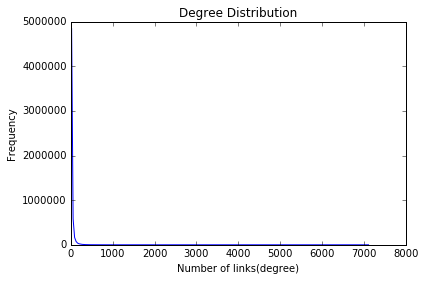

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from wikipediapowerlawdist import wikipediapowerlaw
import subprocess
import numpy as np
#mr_job = wikipediapowerlaw(args=[ '-r', 'local' , 'all-pages-indexed-in.txt'])
mr_job = wikipediapowerlaw(args=['hdfs:///tmp/msannat/wiki_out_input.txt', '-r', 'hadoop' ,  '--no-output', '--cleanup', 'NONE', '--output-dir',  '/tmp/msannat/temp-output' ])

with mr_job.make_runner() as runner: 
    subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
    runner.run()
    links_dist = []
    cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
    for line in cat.stdout:
    #for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        links_dist.append(value)

y,binEdges=np.histogram(links_dist,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'-')
plt.title("Degree Distribution")
plt.xlabel("Number of links(degree)")
plt.ylabel("Frequency")
plt.show()


### It seens to closely follow a power law distribution.

## Section 5 : Shortest path graph distances (Wikipedia)
Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse the code from section 3, but once again be warned of Wikipedia being a directed network.
To be sure of the code's functionality in this context, run a systems test on the directed_toy.txt network.

When running the code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show the code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of MapReduce join skills!!)

Once the code is running, find some other shortest paths and report the results.


In [31]:
%%writefile BFSParallelWikiPedia.py


from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys


class BFSParallelWikiPedia(MRJob):
    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,
                       mapper=self.mapper,
                       combiner=None,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       reducer_final=self.reducer_final)
                ]
    
    
    def configure_options(self):
        super(BFSParallelWikiPedia, self).configure_options()
        self.add_passthrough_option('--startnode', default='1', type=str, help='start node for single source shortest path')
        self.add_passthrough_option('--endnode', default=None, type=str, help='target node to be visited')
    
    def mapper_init(self):
        self.startnode = self.options.startnode
    
    def mapper(self, _, line):
        
        distance = sys.maxint
        path =[]
        status= None
        node = None
        edges = None
        
        node, graph_values = line.strip().split('\t')
        node =  node.strip('"')
        values = graph_values.strip('"').split("|")
        edges = ast.literal_eval(values[0])

        if len(values) == 4:
            distance = int(values[1])
            path = ast.literal_eval(values[2])
            status = values[3]
        
        if status == None:
            if self.startnode == node:
                distance = 0
                status = 'queued'
        if status == 'queued':
            yield node, (edges, distance, path,  'visited')
            path.append(node)
            for node in edges.iterkeys():
                yield node, (None,  distance+1, path,'queued')
        else:
            yield node, (edges,  distance, path,status)



    def reducer_init(self):
        self.endnode = self.options.endnode
        self.endnode_reached = False
        self.final_path = None


    def reducer(self, key, values):
        edges = {}
        distance= []
        status = []
        path = []
        curr_state = None
        
        
        for value in values:
            edges_t = value[0]
            path_t = value[2]
            distance_t = value[1]
            status_t = value[3]
            
            if status_t == 'visited':
                path = path_t
                edges = edges_t
            else:
                if edges_t != None:
                    edges = edges_t
                if path_t != None and len(path_t) > 0:
                    path = path_t
            distance.append(distance_t)
            status.append(status_t)
        min_distance = min(distance)


        if 'visited' in status:
            curr_state = 'visited'
            if self.endnode != None and key.strip('"') == self.endnode:
                self.endnode_reached = True
                self.final_path = str(key) + "\t" + str(edges) + '|' + str(min_distance) + '|' + str(path) + '|' + "F"
        elif 'queued' in status:
            curr_state = 'queued'
        else:
            curr_state = 'unvisited'

        yield key, str(edges) + '|' + str(min_distance) + '|' + str(path) + '|' + curr_state
    
    def reducer_final(self):
        if self.endnode_reached:
            yield self.final_path.split('\t')[0], self.final_path.split('\t')[1]


if __name__ == '__main__':
    BFSParallelWikiPedia.run()



Overwriting BFSParallelWikiPedia.py


In [32]:
%%writefile BFSParallelWikiPedia_driver.py


from BFSParallelWikiPedia import BFSParallelWikiPedia
import sys
import ast
import subprocess

def ind_lookup(path):
    node_words = []
    with open("wiki_indices.txt","r") as f:
        for line in f.readlines():
            word,index, temp1, temp2 = line.strip().split("\t")
            if int(index) in path:
                node_words.append(word)
    return node_words 

INPUT_GRAPH = sys.argv[1]
START_NODE = sys.argv[2]
END_NODE = sys.argv[3]

mr_job = BFSParallelWikiPedia(args=[INPUT_GRAPH, '--startnode', START_NODE, '--endnode', END_NODE,  '-r', 'hadoop', '--no-output', '--cleanup', 'NONE', '--no-check-input-paths', '--output-dir',  '/tmp/msannat/temp-output' ])
#mr_job = BFSParallelWikiPedia(args=[INPUT_GRAPH, '--startnode', START_NODE, '--endnode', END_NODE,  '-r', 'local' ])

num_interation = 0
endnode_reached = False
#shortest_path_words = []

while (1):
    with mr_job.make_runner() as runner: 
        num_interation += 1
        print "Iteration: ", num_interation
        subprocess.Popen(["hadoop", "fs", "-rm", "-r", "/tmp/msannat/temp-output/"], stdout=None)
        runner.run()
        if num_interation ==1:
            #INPUT_GRAPH = 'undirected_toy_graph_input.txt'
            f = open(INPUT_GRAPH, 'w+')
        else:
            #INPUT_GRAPH = 'undirected_toy_graph_input.txt'
            f = open(INPUT_GRAPH, 'w+')
            
        #cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-00000"], stdout=subprocess.PIPE)
        cat = subprocess.Popen(["hadoop", "fs", "-cat", "/tmp/msannat/temp-output/part-*"], stdout=subprocess.PIPE)
        for line in cat.stdout:
        #for line in runner.stream_output():
            f.writelines(line)
            
            line = line.split('\t')
            node = line[0].strip('"')
            data = line[1].strip('"').split('|')
            edges = data[0]
            distance = data[1]
            path = data[2]
            status = data[3].replace('"', "")

            if status[0] == 'F' :
                min_distance = distance
                endnode_reached = True
                path = ast.literal_eval(path)
                shortest_path = ' -> '.join(path) + " -> " + node
                #shortest_path_words = ' -> '.join(ind_lookup(path))  + ' -> ' + ' -> '.join(ind_lookup([node]))
                shortest_path_words = ' -> '.join(ind_lookup([int(v) for v in path]))  + ' -> ' + ' -> '.join(ind_lookup([int(node)]))

                
            
        if endnode_reached:
            break
    f.close()


print "number of iterations {}".format(num_interation)
print "shortest distance from node {} to node {} is: {} with path: [{}] and words : [{}] ".format(START_NODE, END_NODE, min_distance, shortest_path, shortest_path_words)



Overwriting BFSParallelWikiPedia_driver.py


In [33]:
!chmod a+x ./BFSParallelWikiPedia_driver.py

In [36]:
#!hdfs dfs -cp -f hdfs:/tmp/hw7/wiki_out.txt hdfs:/tmp/msannat/wiki_out_input.txt
!python ./BFSParallelWikiPedia_driver.py ./wiki_out.txt 6176135 13466359


Iteration:  1
rm: `/tmp/msannat/temp-output/': No such file or directory
Iteration:  2
17/03/14 06:48:24 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/tmp/msannat/temp-output' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/manishsannat/.Trash/Current
number of iterations 2
shortest distance from node 6176135 to node 13466359 is: 2 with path: [6176135 -> 12905382 -> 4324398 -> 13466359] and words :  [Ireland -> The Washington Post -> Eugene Meyer (financier) -> University of California, Berkeley]
